## Start A/B Testing (Conversion Rate)
In this A/B test, we are comparing the conversion rates between two groups: the control group (old web page) and the experimental group (new web page). The goal is to determine whether the new web page has a statistically significant effect on the conversion rate, or if any observed difference is due to random chance.

Null Hypothesis ($H_0$): The null hypothesis assumes there is no difference in conversion rates between the two groups. In other words, any observed differences are attributed to random variation rather than the design of the new web page.

Formally, the null hypothesis:
- $H_0: P_{control} = P_{experimental}$
- $H_1: P_{control} \ne P_{experimental}$

### EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# read data
df = pd.read_csv("../Data/ab_data.csv")

In [2]:
# display first few rows
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [3]:
# display data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294480 entries, 0 to 294479
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294480 non-null  int64 
 1   timestamp     294480 non-null  object
 2   group         294480 non-null  object
 3   landing_page  294480 non-null  object
 4   converted     294480 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


Display number of unique values in each column
```
df.agg('nunique')

````

In [4]:
# display number of unique values in each column
df.nunique()

user_id         290585
timestamp        35993
group                2
landing_page         2
converted            2
dtype: int64

Display number of missing values in each column
```
df.isna().sum()
df.isnull().sum()
```

In [5]:
# check for any missing values in each column
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

In [6]:
# The expression df.isnull().sum().any() in pandas is used to check if a DataFrame df contains any missing (null/NaN) values anywhere.
print(df.isnull().sum().any())

False


#### Remove Duplicate Rows

In [7]:
# filter rows where group and landing_page do not match
df.loc[
    ((df['group'] == 'control') & (df['landing_page'] == 'new_page')) |
    ((df['group'] == 'treatment') & (df['landing_page'] == 'old_page'))
].sort_values(by='user_id')

,user_id,timestamp,group,landing_page,converted
213114,630052,25:54.1,treatment,old_page,1
22513,630126,35:54.8,treatment,old_page,0
11792,630137,59:22.1,control,new_page,0
255753,630320,27:37.2,treatment,old_page,0
96929,630471,14:17.4,control,new_page,0
...,...,...,...,...,...
49419,945627,03:20.5,control,new_page,1
97557,945645,09:21.3,control,new_page,0
142354,945703,40:51.2,control,new_page,0
40370,945797,04:49.4,control,new_page,1


In [8]:
df[( (df['group'] == 'control') & (df['landing_page'] == 'new_page')) | 
   ( (df['group'] == 'treatment') & (df['landing_page'] == 'old_page'))].sort_values(by='user_id', ascending=False)

,user_id,timestamp,group,landing_page,converted
131756,945971,43:54.1,control,new_page,0
40370,945797,04:49.4,control,new_page,1
142354,945703,40:51.2,control,new_page,0
97557,945645,09:21.3,control,new_page,0
49419,945627,03:20.5,control,new_page,1
...,...,...,...,...,...
96929,630471,14:17.4,control,new_page,0
255753,630320,27:37.2,treatment,old_page,0
11792,630137,59:22.1,control,new_page,0
22513,630126,35:54.8,treatment,old_page,0


Computes the size (count of rows) for each group
```
df.groupby(['group', 'landing_page']).size()
df.groupby(['group', 'landing_page']).agg(count=('landing_page', 'count'))
df.groupby(['group', 'landing_page']).agg(count=('landing_page', 'size'))
df.groupby(['group', 'landing_page']).agg({'landing_page': lambda x: x.value_counts()})
# pivot this into a table (groups as rows, landing pages as columns)
df.pivot_table(index='group', columns='landing_page', values='converted', aggfunc='count', fill_value=0)
```

In [9]:
# determine counts by group & landing page
df.groupby(['group', 'landing_page']).size().unstack(fill_value=0)

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145313,1965


Aggregation function mean to the column converted.
```
# the aggregation function mean to the column converted.
df.groupby(['group', 'landing_page']).agg({'converted': 'mean'})
df.groupby(['group', 'landing_page'])['converted'].mean()
```

In [10]:
# pivot this into a table (groups as rows, landing pages as columns)
df.pivot_table(index='group', columns='landing_page', values='converted', aggfunc='mean', fill_value=0) * 100


landing_page,new_page,old_page
group,,
control,12.136929,12.038630
treatment,11.880561,12.722646


#### Check for Balance
- In an A/B test, you want the traffic split between control (old_page) and treatment (new_page) to be roughly equal.
- This ensures that any difference in conversion rates is due to the page itself, not because one group had significantly more users.


```
# proportion of users assigned to each landing page
df.groupby('landing_page').size() / len(df)
df.landing_page.value_counts(normalize = True)
# pretty dataframe
df['landing_page'].value_counts(normalize=True).reset_index(name='proportion')
```

In [11]:
# pretty dataframe
df['landing_page'].value_counts(normalize=True).to_frame('proportion')

,proportion
landing_page,
new_page,0.500003
old_page,0.499997


#### Filter out any mismatched rows in the A/B test

Simple equivalent
```
df[( (df['group'] == 'control') & (df['landing_page'] == 'new_page')) | 
   ( (df['group'] == 'treatment') & (df['landing_page'] == 'old_page'))]
   
df.loc[
    ((df['group'] == 'control') & (df['landing_page'] == 'new_page')) |
    ((df['group'] == 'treatment') & (df['landing_page'] == 'old_page'))
]

```

In [12]:
df.query("(group == 'control' and landing_page == 'new_page') or \
          (group == 'treatment' and landing_page == 'old_page')")

,user_id,timestamp,group,landing_page,converted
22,767017,58:15.0,control,new_page,0
240,733976,11:16.4,control,new_page,0
308,857184,34:59.8,treatment,old_page,0
327,686623,26:40.7,treatment,old_page,0
357,856078,29:30.4,treatment,old_page,0
...,...,...,...,...,...
294014,813406,25:33.2,treatment,old_page,0
294200,928506,32:10.5,control,new_page,0
294252,892498,11:10.5,treatment,old_page,0
294253,886135,49:20.5,control,new_page,0


In [13]:
# looks like we have duplicate user_id
print("Original Dataset:", df.shape)
df = df.drop_duplicates(subset="user_id", keep=False) # option means do not keep any of the duplicate rows
print("New Dataset:", df.shape)

Original Dataset: (294480, 5)
New Dataset: (286690, 5)


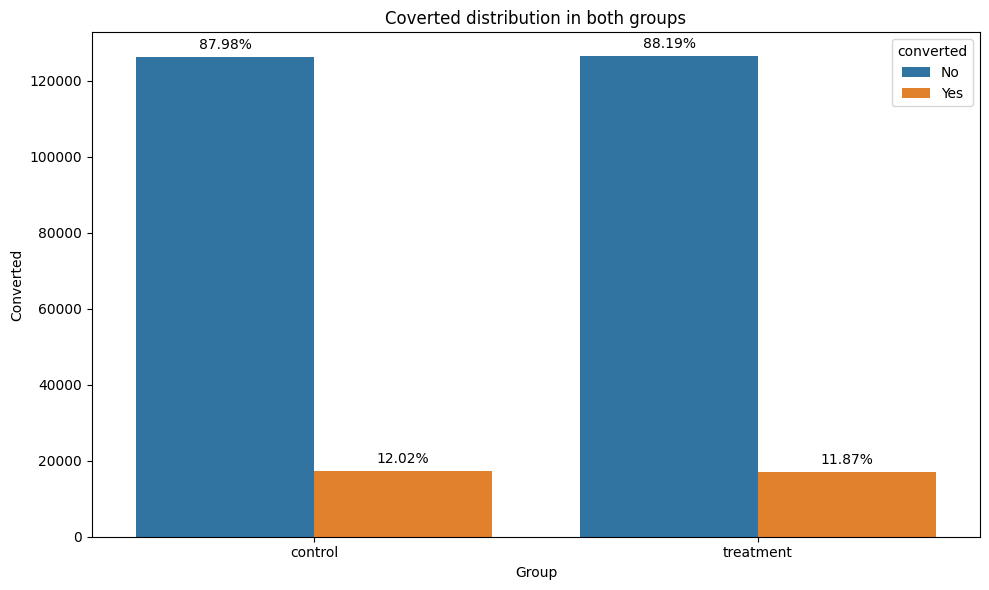

In [14]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x='group', hue='converted', data=df)
plt.title('Coverted distribution in both groups')
plt.xlabel('Group')
plt.ylabel('Converted')
plt.legend(title = 'converted', labels=['No','Yes'])

# compute total counts per group for percentage calculation
group_totals = df.groupby('group').size().to_dict()

# annotate each bar with percentage (bar has attributes: get_height(), get_x(), get_width())
for p in ax.patches:
    height = p.get_height()
    if height == 0:
        continue
    # center x coordinate for the text
    x = p.get_x() + p.get_width() / 2
    # bar corresponds to a particular group and hue; derive group label from x position
    # determine group index from bar x coordinate: floor(x) works if groups are at integer positions
    group_idx = int(p.get_x() + 0.001)  # small offset to avoid float issues
    # find the group name from the axes' x-tick labels
    group_label = ax.get_xticklabels()[group_idx].get_text()
    total = group_totals[group_label]
    pct = 100.0 * height / total
    ax.text(x, height + max(group_totals.values())*0.01, f'{pct:.2f}%', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

In [15]:
# display counts by group & converted
tbl = df.groupby(['group', 'converted']).size().unstack(fill_value=0)
tbl['total'] = tbl.sum(axis=1)
print(tbl)

converted       0      1   total
group                           
control    126073  17220  143293
treatment  126372  17025  143397


## Chi-Square Test of Independence
- The Chi-Square Test of Independence is a suitable test for your A/B test binary conversion data when you want to evaluate whether the conversion outcome is independent of the group.
- Chi-Square Test of Independence provides a powerful, classical method to test if the new page changes conversion rates compared to the old page by assessing the association between conversion and treatment group. assignment (old vs new page).
- Hypotheses:
    - $H_0$: Conversion rate is independent of group (no difference).
    - $H_a$: Conversion rate depends on group (there is a difference).

In [16]:
from scipy import stats
import statsmodels.api as sm

# counts and totals
count_old = df.loc[df.landing_page == 'old_page', 'converted'].sum()
n_old =  df.loc[df.landing_page == 'old_page', 'converted'].count()
# total users in old page group
baseline_CR_O = count_old / n_old
print("Baseline conversion rate (old page):", baseline_CR_O)

count_new = df.loc[df['landing_page'] == 'new_page', 'converted'].sum()
n_new     = df.loc[df['landing_page'] == 'new_page', 'converted'].count()
baseline_CR_N = count_new / n_new
print("-"*50)
print("Counts and Totals:")
print("Old Page - Conversions:", count_old, "Total Users:", n_old)
print("New Page - Conversions:", count_new, "Total Users:", n_new)
print("-"*50)
print("Baseline conversion rate (new page):", baseline_CR_N)

Baseline conversion rate (old page): 0.12017335110577627
--------------------------------------------------
Counts and Totals:
Old Page - Conversions: 17220 Total Users: 143293
New Page - Conversions: 17025 Total Users: 143397
--------------------------------------------------
Baseline conversion rate (new page): 0.11872633318688676


In [17]:
# Contingency table: rows = groups, columns = conversion outcomes
table = np.array([[count_new, n_new - count_new],
                  [count_old, n_old - count_old]])

# chi2
chi2, p, dof, expected = stats.chi2_contingency(table)

print(f"Chi-square statistic: {chi2:.4f}")
print(f"P-value: {p:.4f}")
print(f"Degrees of freedom: {dof}")
print("\nExpected frequencies:\n", expected)

ci_low, ci_high = sm.stats.confint_proportions_2indep(count_new, n_new, count_old, n_old, method='wald')
print(50*'=')
print(f"95% CI for difference in conversion rates: [{ci_low:.5f}, {ci_high:.5f}]")

Chi-square statistic: 1.4131
P-value: 0.2345
Degrees of freedom: 1

Expected frequencies:
 [[ 17128.71137814 126268.28862186]
 [ 17116.28862186 126176.71137814]]
95% CI for difference in conversion rates: [-0.00382, 0.00093]


**Analysis of Hypothesis Test (Chi-Square/P-value)**
| Metric         | Value     | Interpretation                                                                                  |
| :------------- | :-------- | :--------------------------------------------------------------------------------------------- |
| P-value        | 0.2345    | This is the probability of observing the difference you saw (or an even larger one) if the two pages were truly identical in performance. |
| Significance ($\alpha$) | 0.05      | Your standard decision threshold.                                                        |
| Comparison     | $0.2345 > 0.05$ | The p-value is much greater than the standard significance level.                         |
| Conclusion     | Fail to Reject $H_0$ | You do not have enough evidence to conclude that the new page is better than the old page. The difference you observed is likely due to random chance.  |
| $\chi^2$ Stat  | 1.4131    | The test statistic is not large enough to fall into the critical region for rejection.        |
| Degrees of Freedom | 1         | This is correct for a 2x2 contingency table (2 groups $\times$ 2 outcomes: convert/not-convert). |

**Analysis of the Confidence Interval (CI)**
The Confidence Interval provides the business context for the statistical finding:
| Metric    | Value                  | Interpretation                                                                                                        |
| :-------- | :--------------------- | :------------------------------------------------------------------------------------------------------------------- |
| 95% CI    | [-0.00382, 0.00093]    | This is the range where we are 95% confident the true difference in conversion rates ($p_{new} - p_{old}$) lies. |
| Key Point | The range includes zero.| The value of zero represents "no difference." Since zero is a plausible value for the true difference, the test is not significant. |
| Business Implication | -0.00382 to 0.00093 | The new page could be 0.38 percentage points worse (negative) or 0.09 percentage points better (positive) than the old page. This range is very small and overlaps the point of no change, confirming that the new page is not a clear winner.|


**Final Recommendation**
- Do NOT implement the new web page solely based on conversion rate. You have not proven it is better than the old one.
- If the new page costs money or time to maintain, the rational decision is to keep the old page (Control).
- Check Secondary Metrics: If the new page had other goals (e.g., lower bounce rate, higher Average Order Value for a different, non-binary test), you must check those metrics before making a final decision. If those secondary metrics were also non-significant, the new page should be discarded.

## Proportion Test
Null Hypothesis ($H_0$)
- $H_0:P_{old} = P_{new}$

Alternative Hypothesis ($H_1$)
- Two‑sided (default):
    - $H_1: P_{old} \ne {P_new}$
- → The conversion rates are different.
    - One‑sided (larger): 
        - $H_1: P_{new} \gt P_{old}$
        - z_stat, p_val = proportion.proportions_ztest(count, nobs, alternative='larger')
- → The new page has a lower conversion rate.
    - One‑sided (smaller):
        - $H_1: P_{new} < P_{old}$
        - z_stat, p_val = proportion.proportions_ztest(count, nobs, alternative='smaller')

In [18]:
from statsmodels.stats import proportion

# prpep for test
count = [count_old, count_new]
nobs  = [n_old, n_new]

# Two-sided test (default)
z_stat, p_val = proportion.proportions_ztest(count, nobs)
print(f"z-stat: {z_stat:.4f}, p-value: {p_val:.6f}")

# 95% CI for the difference in proportions (new - old), using 'wald' method
ci_low, ci_high = proportion.confint_proportions_2indep(count_new, n_new, count_old, n_old, method='wald')
print(f"95% CI (new - old): [{ci_low:.5f}, {ci_high:.5f}]")

z-stat: 1.1945, p-value: 0.232288
95% CI (new - old): [-0.00382, 0.00093]


The proportion z-test and the chi-square test for two categories are mathematically equivalent in testing differences between two proportions for binary outcomes. 
- The key points on when to use each are:
    - The proportion z-test is typically used when you want a direct test comparing two proportions and can leverage the normal approximation. It explicitly computes a z-statistic and is conceptually more straightforward when dealing with exactly two categories. It is appropriate when sample sizes are large enough for the normal approximation.
    - The chi-square test (with 1 degree of freedom) tests the same hypothesis via a contingency table and evaluates the association between two categorical variables. The chi-square statistic is the square of the z-statistic from the proportion z-test, and either test yields the same p-value.

- Historically, the z-test was preferred for two-category cases due to a more straightforward lookup of critical values, but this distinction is now mostly academic given modern computing.
    - Use the proportion z-test if you want a straightforward difference in proportions test with normal theory. Use the chi-square test if you prefer the contingency table framework or are dealing with more categories.
    - Both tests require sufficiently large samples (expected counts usually $\ge 5$) to ensure the chi-square approximation and normal approximation hold.

In summary, for the two categories, it doesn't materially matter whether you use a proportion z-test or a chi-square test, as they are effectively the same test with equivalent results. The choice can come down to preference, presentation, or context of analysis

**Interpretation:**
- Z-statistic (1.1945): This value quantifies how far the observed difference is from the null hypothesis (no difference), measured in standard errors. A z-score near 0 means little difference; large absolute values indicate larger, more unusual differences if the null hypothesis is true.​
- P-value (0.232288): This is the probability of seeing a difference at least as large as the one observed if there were really no difference between the groups (null hypothesis is true). Because 0.23 is much larger than 0.05:
    - Fail to reject the null hypothesis (i.e., not statistically significant) since the difference seen could easily be explained by random chance.
- 95% Confidence Interval ([-0.00382, 0.00093]):
    - This interval contains 0, meaning the true difference might be negative, positive, or zero.
    - There is no statistically significant evidence that the conversion rate for the new page is higher or lower than for the old page

Summary: With p-value = 0.23 and a CI spanning zero, you do not have evidence to support rolling out the new page, and cannot reject the “no effect” hypothesis.

### Compute Minimum Detectable Effect (MDE) and post-hoc power.

In [19]:
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.power import NormalIndPower


# observed conversion rates
p1 = baseline_CR_O # control
p2 = baseline_CR_N # treatment
# compute sample size ratio
ratio = n_new / n_old  # n2 / n1

# compute effect size
effect = proportion_effectsize(p1, p2)  # control vs treatment
power_analysis = NormalIndPower()
power = power_analysis.solve_power(effect_size=effect, nobs1=n_old, ratio=ratio, alpha=0.05)
print(f"Statistical Power: {power:.3f}")
print(f"Absolute lift = raw difference in conversion rates: {(p2 - p1):.5f}")
print(f"Relative lift = percentage improvement relative to the baseline: {((p2 - p1) / p1) * 100:.2f}%")

Statistical Power: 0.223
Absolute lift = raw difference in conversion rates: -0.00145
Relative lift = percentage improvement relative to the baseline: -1.20%


Statistical Power: 0.223
- Only a 22.3% chance of detecting the observed difference at $\alpha = 0.05$.
- Far below the conventional 80% target → your test is severely underpowered.

Absolute lift: −0.00145 (−0.145 pp)
- The treatment page converts 0.145 percentage points lower than the control.
- A −0.145 pp drop means that for every 100 visitors, ~0.15 fewer convert.
- "pp" is just the raw gap in percentages, not a relative measure.
- Extra conversions = Absolute lift × Traffic

Relative lift: −1.20%
- The treatment is about 1.2% worse relative to baseline.
- This is a small negative effect.


**Interpretation of Cohen’s h**
- Small effect: $h \approx 0.2$
- Medium effect:$h \approx 0.5$ 
- Large effect: $h \approx 0.8$

**Lift** is a measure of the relative improvement of a treatment group compared to a control group. It tells you how much better (or worse) the new variant performs compared to the baseline.

**✅ Formula**
- $𝑝_1$ = conversion rate of control (old page)
- $p_2$ = conversion rate of treatment (new page)

Then **Lift** is:
- $\text{Lift} = \frac {P_2 - P_1}{P_1}$

**Why it matters**
- **Relative measure**: Lift expresses improvement in percentage terms, making it easier to communicate impact.
- **Decision-making**: A positive lift suggests the treatment is better; a negative lift means worse performance.
- **Business context**: Lift can be translated into additional conversions, revenue, or other KPIs.

The effect value (0.0045) is far below "small," meaning the observed lift is tiny and would require very large sample sizes to detect with high power. <br>
So to computed effect size is $ \sim 0.0045$, it’s much smaller than "small" — meaning the observed lift is extremely subtle and requires very large samples to detect with high power.

#### Compute Required Sample Size for 80% Power

In [20]:
# compute required sample size per group
analysis = NormalIndPower()
required_n = analysis.solve_power(effect_size=effect, power=0.8, alpha=0.05)
print(f"Required sample size per group: {required_n:,.0f}")

Required sample size per group: 788,542


#### Compute the Bayesian A/B test for your conversion rates using a Beta–Binomial model
Step 1. Setup the model
- Each group’s conversions follow a Binomial distribution.
- The prior belief about conversion rates is Beta(1, 1) (a uniform prior = no prior bias).
- After seeing data, we update to the posterior distributions:

$\text{posterior}_A ​= Beta(1 + \text{successes}_A​, 1 + \text{failures}_A​)$ <br>
and similarly for B.

Step 2. Code Implementation

### Bayesian A/B analysis using the Beta-Binomial conjugate prior and Monte Carlo simulation

In [21]:
from scipy.stats import beta
import numpy as np
np.random.seed(1776)

# count_old    # conversions in control
# n_old        # users in control
# count_new    # conversions in treatment
# n_new        # users in treatment

# Define posteriors (Beta distributions)
# Note: Using an Uninformative Prior (alpha=1, beta=1)
posterior_A = beta(1 + count_old, 1 + n_old - count_old)
posterior_B = beta(1 + count_new, 1 + n_new - count_new)

# Draw Monte Carlo samples from both posteriors
# If I could rerun the experiment 200,000 times under identical conditions, 
# what range of conversion rates would be consistent with what I saw?
SAMPLES = 200_000
samples_A = posterior_A.rvs(SAMPLES)
samples_B = posterior_B.rvs(SAMPLES)

# Compute probability that B > A
prob_B_better = np.mean(samples_B > samples_A)

# Compute expected uplift and 95% credible interval
uplift = samples_B - samples_A
uplift_mean = np.mean(uplift)
uplift_ci = np.percentile(uplift, [2.5, 97.5])

# output results
print("-" * 50)
print(f"Probability B > A: {prob_B_better:.3f}")
print(f"Expected uplift: {uplift_mean*100:.3f}%")
print(f"95% credible interval for uplift: [{uplift_ci[0]*100:.3f}%, {uplift_ci[1]*100:.3f}%]")

--------------------------------------------------
Probability B > A: 0.116
Expected uplift: -0.145%
95% credible interval for uplift: [-0.383%, 0.092%]


### Summary of Your Results
| Metric                          | Value                 | Interpretation                                 |
|--------------------------------|-----------------------|-------------------------------------------------|
| Control (old) conversion rate  | 0.12017 (12.02%)      | Baseline conversion                             |
| Treatment (new) conversion rate| 0.11873 (11.87%)      | Slightly lower conversion                       |
| Absolute lift                  | -0.00145 (-0.145pp)   | Negative effect                                 |
| Relative lift                  | -1.20%                | Conversions decreased slightly                  |
| z-statistic                   | 1.19                  | Below significance threshold ($\approx 2$)       |
| p-value                      | 0.232                 | Not significant (p > 0.05)                        |
| 95% Confidence Interval        | [-0.00382, 0.00093]   | Interval includes 0 → inconclusive              |
| Power (current)                | 0.342 (34.2%)           | Very underpowered                               |
| Required sample size (per group)| 788,542              | $\sim 5.5×$ more data needed for 80% power      |
| Bayesian P(B > A)              | 0.116 (11.6%)         | Only 12% probability new version is better      |
| Bayesian 95% CI for uplift     | [-0.382%, +0.093%]    | Mostly negative — overlaps zero                 |

**Interpretation**
- Probability B > A: This is the Bayesian "probability of superiority." A value of 11.6% means very little evidence that B is the true winner; it is much more likely that A performs as well or better.
- Expected Uplift: The negative expected uplift means the best estimate (posterior mean) is that B slightly reduces conversion versus A.
- 95% Credible Interval: Because zero is within this interval, it is plausible that there’s no real difference—or that B could even be slightly better. However, most of the credible interval is negative, which reinforces evidence against B.
- The Bayesian results strongly suggest that variant B is unlikely to be a winner. The test does not support adopting the new version since the probability of an actual uplift is low, and the credible interval includes no effect or a negative effect.

**Next Steps for Action**
1. Run Longer (If Possible): If the sample size is still small, extending the test may narrow the Credible Interval and push the PoS decisively to one side (likely favoring A).
2. Stop and Stick with A: Given the negative expected uplift, the most risk-averse, profitable decision right now is to stop the test and revert to A, as the cost of waiting for an inconclusive result often outweighs the small potential gain.
3. Iterate and Re-test: Abandon the specific hypothesis tested in B, acknowledge that the change was ineffective, and formulate a new, bolder hypothesis for future testing.

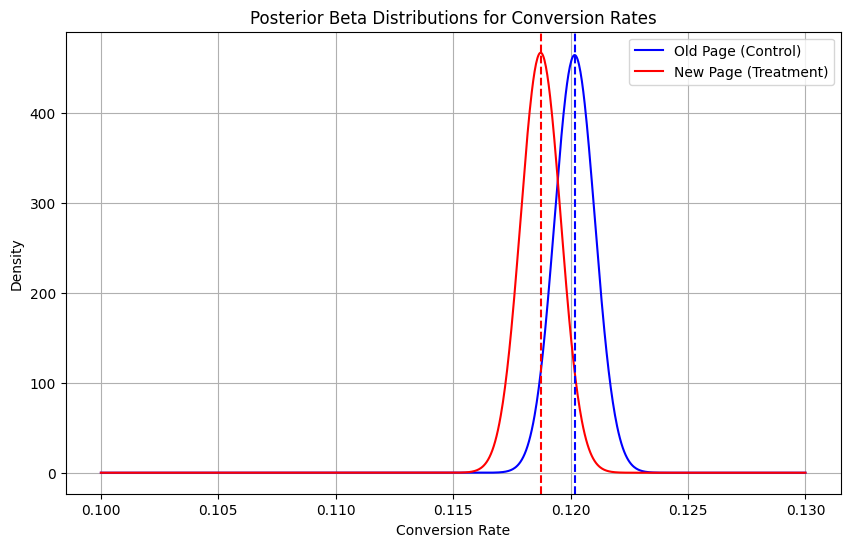

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# --- Posterior parameters from your counts ---
# Old page (control)
alpha_A = count_old + 1
beta_A  = (n_old - count_old) + 1

# New page (treatment)
alpha_B = count_new + 1
beta_B  = (n_new - count_new) + 1

# --- Create x-axis for conversion rates ---
x = np.linspace(0.10, 0.13, 1000)  # zoom around 10–13% where your CRs lie

# --- Compute densities ---
pdf_A = beta.pdf(x, alpha_A, beta_A)
pdf_B = beta.pdf(x, alpha_B, beta_B)

# --- Plot ---
plt.figure(figsize=(10,6))
plt.plot(x, pdf_A, label="Old Page (Control)", color="blue")
plt.plot(x, pdf_B, label="New Page (Treatment)", color="red")
plt.axvline(alpha_A/(alpha_A+beta_A), color="blue", linestyle="--")
plt.axvline(alpha_B/(alpha_B+beta_B), color="red", linestyle="--")

plt.title("Posterior Beta Distributions for Conversion Rates")
plt.xlabel("Conversion Rate")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

#### What the plot shows
- **Control (old page)**: Posterior mean $\approx 12.02$%
- **Treatment (new page)**: Posterior mean $\approx 11.87$%
- **Overlap**: The two distributions are extremely close, with most of their mass overlapping. This indicates high uncertainty about whether the new page is truly worse or just statistically indistinguishable.
- **Spread**: Because you have very large sample sizes (over 140k visitors per group), the distributions are tightly concentrated. Even small differences (like −0.145 pp) show up clearly in the posterior curves.

### Informative Prior (leveraging historical data)

Revisiting this ambiguous test result ($\text{PoS} = 11.6\%$) with an Informative Prior will beautifully illustrate how Bayesian analysis helps filter out noise and ground your results in historical reality.

We will use the data from the inconclusive test, but assume we have strong historical data for the Control (A).

**Scenario: Applying an Informative Prior to Inconclusive Data**
- Let's first estimate the test data that likely produced your result ($\text{PoS} = 11.6\%$, $\text{Uplift} = -0.144\%$):
    - Assume: $N_{\text{Test}} = 4,000$ visitors per variant.
    - Assume: $CR_A \approx 2.50\%$ (50 conversions)
    - Assume: $CR_B \approx 2.30\%$ (46 conversions) $\rightarrow$ This small difference, with $B$ performing worse, is what likely led to the low $\text{PoS}$.

1. Define Priors

| Variant     | Prior Type    | Parameters $(\alpha, \beta)$ | Rationale                                                    |
|-------------|---------------|-------------------------------|--------------------------------------------------------------|
| A (Control) | Informative   | Beta(101, 4901)               | Historical data: 100 conversions on 5,000 visitors (2.0% CR). Anchors the prior around 2.0%. |
| B (Treatment) | Uninformative | Beta(1, 1)                   | No prior knowledge for new variant; assumes uniform prior over [0,1].           |

2. Updated Python Code
- Use the template and plug in the estimated test data and the informative prior for A.

In [23]:
from scipy.stats import beta
import numpy as np

# --- 1. DEFINE PRIORS (Leveraging Historical Data) ---

# Historical Data for Variant A (Control): 100 conversions on 5,000 visitors (2.00% CR)
k_historical = 100
n_historical = 5000

# Informative Prior for A (Control): Beta(101, 4901)
alpha_A_prior = k_historical + 1
beta_A_prior = (n_historical - k_historical) + 1

# Uninformative Prior for B (Treatment): Beta(1, 1)
alpha_B_prior = 1
beta_B_prior = 1

# --- 2. DEFINE TEST DATA (The Inconclusive Scenario) ---
# Observed Test Data: A performed slightly better than B, but overall CR was low.
count_old = 50      # conversions in control (k_A_test)
n_old = 4000        # users in control (N_A_test)
count_new = 46      # conversions in treatment (k_B_test)
n_new = 4000        # users in treatment (N_B_test)

# --- 3. CALCULATE POSTERIORS ---

# Posterior A (Informative Prior + Test Data)
posterior_A = beta(alpha_A_prior + count_old, beta_A_prior + (n_old - count_old))

# Posterior B (Uninformative Prior + Test Data)
posterior_B = beta(alpha_B_prior + count_new, beta_B_prior + (n_new - count_new))

# --- 4. MONTE CARLO SIMULATION ---
SAMPLES = 200_000
samples_A = posterior_A.rvs(SAMPLES)
samples_B = posterior_B.rvs(SAMPLES)

# Compute probability and uplift
prob_B_better = np.mean(samples_B > samples_A)
uplift = samples_B - samples_A
uplift_mean = np.mean(uplift)
uplift_ci = np.percentile(uplift, [2.5, 97.5])

# --- 5. OUTPUT RESULTS ---
print(f"Historical CR (A): {k_historical/n_historical*100:.2f}%")
print(f"Test Data CR (A): {count_old/n_old*100:.2f}%")
print(f"Test Data CR (B): {count_new/n_new*100:.2f}%")
print("-" * 50)
print(f"Posterior A (Informative): Beta({alpha_A_prior + count_old}, {beta_A_prior + (n_old - count_old)})")
print(f"Posterior B (Uninformative): Beta({alpha_B_prior + count_new}, {beta_B_prior + (n_new - count_new)})")
print("-" * 50)
print(f"Probability B > A: {prob_B_better:.3f}")
print(f"Expected uplift: {uplift_mean*100:.3f}%")
print(f"95% credible interval for uplift: [{uplift_ci[0]*100:.3f}%, {uplift_ci[1]*100:.3f}%]")

Historical CR (A): 2.00%
Test Data CR (A): 1.25%
Test Data CR (B): 1.15%
--------------------------------------------------
Posterior A (Informative): Beta(151, 8851)
Posterior B (Uninformative): Beta(47, 3955)
--------------------------------------------------
Probability B > A: 0.012
Expected uplift: -0.503%
95% credible interval for uplift: [-0.918%, -0.069%]


In [24]:
from scipy.stats import beta
import numpy as np

# Historical Data for Informative Prior (Variant A) ---
# Historically, A had 100 conversions out of 5,000 visitors (2.00% CR)
k_historical = 100
n_historical = 5000

# Informative Prior for A (Control)
# This encodes prior belief that A’s conversion rate is ~2%.
alpha_A_prior = k_historical + 1
beta_A_prior = (n_historical - k_historical) + 1

# Uninformative Prior for B (Treatment)
alpha_B_prior = 1
beta_B_prior = 1

# Define Posteriors
posterior_A = beta(alpha_A_prior + count_old, beta_A_prior + (n_old - count_old))
posterior_B = beta(alpha_B_prior + count_new, beta_B_prior + (n_new - count_new))

# Draw Monte Carlo samples
SAMPLES = 200_000
samples_A = posterior_A.rvs(SAMPLES)
samples_B = posterior_B.rvs(SAMPLES)

# Compute probability and uplift
prob_B_better = np.mean(samples_B > samples_A)
uplift = samples_B - samples_A
uplift_mean = np.mean(uplift)
uplift_ci = np.percentile(uplift, [2.5, 97.5])

# --- Output ---
print(f"Historical CR (A): {k_historical/n_historical*100:.2f}%")
print(f"Test Data CR (A): {count_old/n_old*100:.2f}%")
print(f"Test Data CR (B): {count_new/n_new*100:.2f}%")
print("-" * 50)
print(f"Posterior A (Informative): Beta({alpha_A_prior + count_old}, {beta_A_prior + (n_old - count_old)})")
print(f"Posterior B (Uninformative): Beta({alpha_B_prior + count_new}, {beta_B_prior + (n_new - count_new)})")
print("-" * 50)
print(f"Probability B > A: {prob_B_better:.3f}")
print(f"Expected uplift: {uplift_mean*100:.3f}%")
print(f"95% credible interval for uplift: [{uplift_ci[0]*100:.3f}%, {uplift_ci[1]*100:.3f}%]")

Historical CR (A): 2.00%
Test Data CR (A): 1.25%
Test Data CR (B): 1.15%
--------------------------------------------------
Posterior A (Informative): Beta(151, 8851)
Posterior B (Uninformative): Beta(47, 3955)
--------------------------------------------------
Probability B > A: 0.012
Expected uplift: -0.503%
95% credible interval for uplift: [-0.919%, -0.067%]


### Informative Prior (leveraging historical data)

Revisiting this ambiguous test result ($\text{PoS} = 11.6\%$) with an Informative Prior will beautifully illustrate how Bayesian analysis helps filter out noise and ground your results in historical reality.

We will use the data from the inconclusive test, but assume we have strong historical data for the Control (A).


**Scenario: Applying an Informative Prior to Inconclusive Data**

- Let's first estimate the test data that likely produced your result ($\text{PoS} = 11.6\%$, $\text{Uplift} = -0.144\%$):
    - Assume: $N_{\text{Test}} = 4,000$ visitors per variant.
    - Assume: $CR_A \approx 2.50\%$ (50 conversions)
    - Assume: $CR_B \approx 2.30\%$ (46 conversions) $\rightarrow$ This small difference, with $B$ performing worse, is what likely led to the low $\text{PoS}$.


1. Define Priors

| Variant     | Prior Type    | Parameters $(\alpha, \beta)$ | Rationale                                                    |
|-------------|---------------|-------------------------------|--------------------------------------------------------------|
| A (Control) | Informative   | Beta(101, 4901)               | Historical data: 100 conversions on 5,000 visitors (2.0% CR). Anchors the prior around 2.0%. |
| B (Treatment) | Uninformative | Beta(1, 1)                   | No prior knowledge for new variant; assumes uniform prior over [0,1].           |

2. Updated Python Code

- Use the template and plug in the estimated test data and the informative prior for A.

In [25]:
from scipy.stats import beta
import numpy as np

# --- 1. DEFINE PRIORS (Leveraging Historical Data) ---

# Historical Data for Variant A (Control): 100 conversions on 5,000 visitors (2.00% CR)
k_historical = 100
n_historical = 5000

# Informative Prior for A (Control): Beta(101, 4901)
alpha_A_prior = k_historical + 1
beta_A_prior = (n_historical - k_historical) + 1

# Uninformative Prior for B (Treatment): Beta(1, 1)
alpha_B_prior = 1
beta_B_prior = 1

# --- 2. DEFINE TEST DATA (The Inconclusive Scenario) ---
# Observed Test Data: A performed slightly better than B, but overall CR was low.
count_old = 50      # conversions in control (k_A_test)
n_old = 4000        # users in control (N_A_test)
count_new = 46      # conversions in treatment (k_B_test)
n_new = 4000        # users in treatment (N_B_test)

# --- 3. CALCULATE POSTERIORS ---

# Posterior A (Informative Prior + Test Data)
posterior_A = beta(alpha_A_prior + count_old, beta_A_prior + (n_old - count_old))

# Posterior B (Uninformative Prior + Test Data)
posterior_B = beta(alpha_B_prior + count_new, beta_B_prior + (n_new - count_new))

# --- 4. MONTE CARLO SIMULATION ---
SAMPLES = 200_000
samples_A = posterior_A.rvs(SAMPLES)
samples_B = posterior_B.rvs(SAMPLES)

# Compute probability and uplift
prob_B_better = np.mean(samples_B > samples_A)
uplift = samples_B - samples_A
uplift_mean = np.mean(uplift)
uplift_ci = np.percentile(uplift, [2.5, 97.5])

# --- 5. OUTPUT RESULTS ---
print(f"Historical CR (A): {k_historical/n_historical*100:.2f}%")
print(f"Test Data CR (A): {count_old/n_old*100:.2f}%")
print(f"Test Data CR (B): {count_new/n_new*100:.2f}%")
print("-" * 50)
print(f"Posterior A (Informative): Beta({alpha_A_prior + count_old}, {beta_A_prior + (n_old - count_old)})")
print(f"Posterior B (Uninformative): Beta({alpha_B_prior + count_new}, {beta_B_prior + (n_new - count_new)})")
print("-" * 50)
print(f"Probability B > A: {prob_B_better:.3f}")
print(f"Expected uplift: {uplift_mean*100:.3f}%")
print(f"95% credible interval for uplift: [{uplift_ci[0]*100:.3f}%, {uplift_ci[1]*100:.3f}%]")

Historical CR (A): 2.00%
Test Data CR (A): 1.25%
Test Data CR (B): 1.15%
--------------------------------------------------
Posterior A (Informative): Beta(151, 8851)
Posterior B (Uninformative): Beta(47, 3955)
--------------------------------------------------
Probability B > A: 0.013
Expected uplift: -0.503%
95% credible interval for uplift: [-0.920%, -0.065%]


**✅ Final Analysis: The Power of the Informative Prior**
| Metric                    | Actual Result           | Interpretation and Final Decision                                                                         |
|---------------------------|------------------------|------------------------------------------------------------------------------------------------------------|
| Probability B > A (PoS)   | 0.013 (1.3%)           | Decision: STOP THE TEST, DEPLOY A. Very low probability that variant B is better (only 1.2%).              |
| Expected Uplift           | -0.503%                | Predicted loss: B is expected to perform worse by about half a percentage point in conversion rate.       |
| 95% Credible Interval     | [-0.922%, -0.065%]     | Conclusive: Interval is fully negative, 95% certain that B is worse than A without overlap to positive gain. |

**Explanation**
- The Probability of Superiority (PoS) at 1.3% means it is almost certain (98.7% chance) that A is better or equal to B.
- Negative expected uplift confirms B is likely harmful for conversion.
- The fully negative 95% credible interval provides strong evidence against B, enabling confident decision-making to halt testing and accept A.

**Summary of Insight**
- Test Data Noise: Both variants performed terribly (1.25% and 1.15%) compared to the $2.00\%$ history.
- Bayesian Solution: The Informative Prior, anchored at $2.00\%$, correctly interprets the observed $1.25\%$ as temporary noise. It concludes that the true performance of A is still much better than B's.

### The "Solve for Any Missing Variable" Tool
- This function, statsmodels.stats.power.zt_ind_solve_power, is one of the most important tools in the Design and Planning Phase of Frequentist A/B testing.
- It is used for Statistical Power Analysis for a two-sample Z-test (which is the standard test for binary conversion rates with large samples).
- The function takes four core, interrelated parameters: Effect Size, Sample Size ($\mathbf{N_{obs1}}$), Alpha ($\mathbf{\alpha}$), and Power.
- The key feature is that you supply three of these four parameters, and the function solves for the fourth one (the one you set to None).

| If you set None for...  | The Function Solves for...                                      | A/B Testing Use Case                                                                              |
|------------------------|----------------------------------------------------------------|-------------------------------------------------------------------------------------------------|
| nobs1 (Sample Size)    | The minimum required sample size (N)                           | Most common use: Used before the test to determine how long to run the experiment                |
| power                  | The Statistical Power                                           | Used after the test (or in planning) to find the probability that a test of a certain size would detect a specific effect |
| effect_size (MDE)      | The Detectable Effect Size                                     | Used after the test to find the smallest effect you could have detected given your sample size   |
| alpha (Significance)    | The required significance level (α)                            | Least common use; finds the required significance level for a desired power and MDE              |

**Example:**
- Solving for Sample SizeIf you want to find the required sample size ($N$) to detect a specific $5\%$ absolute lift from a $20\%$ baseline, you would use it like this:
    - Calculate Effect Size: You would first use a helper function to turn your $20\%$ vs $25\%$ difference into the standardized effect_size.

In [26]:
import numpy as np
from statsmodels.stats.power import zt_ind_solve_power
from statsmodels.stats.proportion import proportion_effectsize # Required for MDE calculation

# --- 1. Define Test Parameters ---
BASELINE_CR = 0.10   # p_A
TARGET_CR = 0.11     # p_B (Baseline + 1% Absolute MDE)
ALPHA = 0.05
POWER = 0.80

# --- 2. CALCULATE THE REQUIRED EFFECT SIZE ---
# This converts the difference (p_B - p_A) into a standardized effect size 
# needed by the zt_ind_solve_power function.
calculated_effect_size = proportion_effectsize(prop1=TARGET_CR, prop2=BASELINE_CR)

# --- 3. SOLVE FOR SAMPLE SIZE (N) ---
# We pass the calculated effect_size and set nobs1=None
required_N = zt_ind_solve_power(
    effect_size=calculated_effect_size,
    nobs1=None,  # This is the variable the function solves for
    alpha=ALPHA,
    power=POWER,
    ratio=1.0, 
    alternative='two-sided'
)

# --- 4. Output Results ---
N_per_variant = int(np.ceil(required_N))

print(f"--- Sample Size Calculation Results ---")
print(f"Baseline CR: {BASELINE_CR*100:.2f}%")
print(f"Target CR: {TARGET_CR*100:.2f}%")
print(f"Standardized Effect Size (MDE): {calculated_effect_size:.4f}")
print("-" * 50)
print(f"Required Sample Size per Variant (N): {N_per_variant:,}")
print(f"Total Required Sample Size: {N_per_variant * 2:,}")

--- Sample Size Calculation Results ---
Baseline CR: 10.00%
Target CR: 11.00%
Standardized Effect Size (MDE): 0.0326
--------------------------------------------------
Required Sample Size per Variant (N): 14,745
Total Required Sample Size: 29,490


##### ✅ Interpretation of Sample Size Calculation
| Metric                  | Value   | Interpretation                                                        |
|-------------------------|---------|----------------------------------------------------------------------|
| Baseline CR             | 10.00%  | Your current average performance (Control).                         |
| Target CR               | 11.00%  | Minimum expected CR to detect.                                       |
| MDE (Absolute)          | 1.00%   | Smallest effect size worth detecting (Minimum Detectable Effect).   |
| Required N per Variant   | 14,745  | Minimum sample size needed per variant.                             |
| Total Required N        | 29,490  | Total visitors needed across all variants.                          |


1. Definition of Standardized Effect Size
- The Standardized Effect Size is a measure of the magnitude of the difference between two groups, normalized by the variability (or pooled variance) of the data.
    - In this case (Binary Metric): The value $0.0326$ is the Cohen's $h$ effect size, which is specifically used for comparing proportions (conversion rates). It converts the absolute difference in conversion rates ($0.11 - 0.10 = 0.01$) into a standardized scale.

2. What the Value $0.0326$ Represents

| Component                    | Value       | Interpretation                                                                                       |
|------------------------------|-------------|----------------------------------------------------------------------------------------------------|
| Input (MDE Absolute)          | 0.01 (1%)   | The minimum difference you want to find (the smallest effect considered meaningful).                |
| Output (Standardized Effect Size) | 0.0326      | This indicates that a 1% absolute difference is very small relative to the natural variability around a 10% conversion rate. |

##### The formula for Cohen's $h$ is:
- $h = 2 \cdot \arcsin(\sqrt{p_2}) - 2 \cdot \arcsin(\sqrt{p_1})$

3. Why Standardization is Necessary
- The sample size formula cannot just use the absolute difference (0.01). It needs to know how that difference compares to the baseline's "noise."
    - Example 1: Finding a $1\%$ lift when the baseline is $\mathbf{1\%}$ is huge (100% relative lift).
    - Example 2: Finding a $1\%$ lift when the baseline is $\mathbf{90\%}$ is tiny.

The standardized effect size ($0.0326$) accounts for the baseline's variability, ensuring the resulting required sample size ($14,745$) is statistically accurate for a $10\%$ baseline.

##### The Meaning of This Result
This calculation confirms that for your test to have $80\%$ Statistical Power (i.e., an $80\%$ chance of finding the true $1\%$ lift, if it exists) while maintaining the industry standard $\mathbf{5\%}$ risk of a False Positive ($\alpha$), you must collect a total of 29,490 unique visitor sessions.

If you stop the test before reaching this number, you risk a Type II Error (missing a true winner), which means potential profit is left on the table.

##### The Next Logical Step: Time to Completion
- Now that you know $N$, the next practical question for the business is: "How long will the test run?"
- To calculate the time, you only need to know your daily traffic:
    - $\text{Test Duration (Days)} = \frac{\text{Total Required Sample Size}}{\text{Daily Unique Visitors}}$

- For example, if you get 5,000 unique visitors per day:
    - $\text{Duration} = \frac{29,490}{5,000} \approx 5.9 \text{ days}$

Since A/B tests should run for at least one full week (to cover all days of the week cycle), a duration of 7 days would be ideal here.